In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from collections import Counter

# Load the data
df = pd.read_csv('swami_vivekananda_letters_complete.csv')

# Clean data (remove editorial notes)
df_clean = df[df['Name'].notna() & (df['Name'] != 'EDITORIAL NOTE')].copy()

# Check what columns we actually have
print("Available columns:")
print(df_clean.columns.tolist())
print("\n" + "="*80)
print("PHASE 1 UNEXPLORED DIRECTIONS - BRIEF ANALYSIS")
print("="*80)

# Parse dates first
df_clean['Date_parsed'] = pd.to_datetime(df_clean['Date'], errors='coerce')
df_clean['Year'] = df_clean['Date_parsed'].dt.year
df_sorted = df_clean.sort_values('Date_parsed')

# 1. RESPONSE TIME PATTERNS
print("\n1. RESPONSE TIME PATTERNS")
print("-" * 40)
# Calculate gaps for top 5 recipients
top5 = ['Sarah Bull', 'Christine Sister', 'Mrs. G.W. Hale', 'Sister Nivedita', 'Mary Hale']
for recipient in top5:
    recipient_letters = df_sorted[df_sorted['Name'] == recipient]['Date_parsed'].dropna()
    if len(recipient_letters) > 1:
        gaps = recipient_letters.diff().dt.days.dropna()
        print(f"{recipient}: {len(recipient_letters)} letters, avg gap {gaps.mean():.1f} days, "
              f"median {gaps.median():.1f} days, max gap {gaps.max():.0f} days")

# 2. AUDIENCE TYPE ANALYSIS
print("\n2. AUDIENCE TYPE ANALYSIS")
print("-" * 40)
print(f"Audience column unique values: {df_clean['Audience'].nunique()}")
print(f"Top audience types:\n{df_clean['Audience'].value_counts().head(10)}")
audience_stats = df_clean.groupby('Audience').agg({
    'body_word_count': ['mean', 'median', 'count'],
    'ps_text': lambda x: (x.notna() & (x != '')).sum()
}).round(1)
audience_stats.columns = ['avg_words', 'median_words', 'count', 'ps_count']
audience_stats['ps_rate'] = (audience_stats['ps_count'] / audience_stats['count'] * 100).round(1)
print(f"\nAudience statistics (top 10 by count):")
print(audience_stats.sort_values('count', ascending=False).head(10))

# 3. TYPE COLUMN ANALYSIS
print("\n3. TYPE COLUMN ANALYSIS")
print("-" * 40)
print(f"Type column unique values: {df_clean['Type'].nunique()}")
print(f"Type distribution:\n{df_clean['Type'].value_counts()}")
type_stats = df_clean.groupby('Type').agg({
    'body_word_count': ['mean', 'median'],
    'ps_text': lambda x: (x.notna() & (x != '')).sum()
}).round(1)
type_stats.columns = ['avg_words', 'median_words', 'ps_count']
print(f"\nType statistics:")
print(type_stats)

# 4. CROSS-RECIPIENT PATTERNS (Temporal Overlap)
print("\n4. CROSS-RECIPIENT PATTERNS")
print("-" * 40)
# For top 5, find their active years
for recipient in top5:
    recipient_years = df_clean[df_clean['Name'] == recipient]['Year'].dropna()
    if len(recipient_years) > 0:
        year_range = f"{int(recipient_years.min())}-{int(recipient_years.max())}"
        year_counts = recipient_years.value_counts().sort_index()
        active_years = year_counts[year_counts > 2].index.tolist()
        print(f"{recipient}: {year_range}, peak years: {[int(y) for y in active_years]}")

# 5. LANGUAGE SOPHISTICATION (English only)
print("\n5. LANGUAGE SOPHISTICATION (English letters)")
print("-" * 40)
english_letters = df_clean[df_clean['Language'] == 'English'].copy()
english_letters['avg_word_length'] = english_letters['body_text'].apply(
    lambda x: np.mean([len(word) for word in str(x).split()]) if pd.notna(x) and str(x).strip() else np.nan
)
print(f"Overall avg word length: {english_letters['avg_word_length'].mean():.2f} characters")
# By top recipients
for recipient in top5:
    recipient_letters = english_letters[english_letters['Name'] == recipient]
    avg_wl = recipient_letters['avg_word_length'].mean()
    if not np.isnan(avg_wl):
        print(f"{recipient}: {avg_wl:.2f} chars/word, {len(recipient_letters)} English letters")

# 6. MISSING DATA PATTERNS
print("\n6. MISSING DATA PATTERNS")
print("-" * 40)
print(f"Letters without signature: {(df_clean['signature_text'].isna() | (df_clean['signature_text'] == '')).sum()} / {len(df_clean)}")
print(f"Letters without PS: {(df_clean['ps_text'].isna() | (df_clean['ps_text'] == '')).sum()} / {len(df_clean)}")
print(f"Letters without Place: {df_clean['Place'].isna().sum()} / {len(df_clean)}")
print(f"Letters without Date: {df_clean['Date'].isna().sum()} / {len(df_clean)}")

# Check if missing signature correlates with anything
no_sig = df_clean['signature_text'].isna() | (df_clean['signature_text'] == '')
print(f"\nMissing signature by Language:")
print(pd.crosstab(df_clean['Language'], no_sig, normalize='index').round(3) * 100)

# 7. MICRO-TEMPORAL PATTERNS
print("\n7. MICRO-TEMPORAL PATTERNS")
print("-" * 40)
df_clean['Month'] = df_clean['Date_parsed'].dt.month
month_counts = df_clean['Month'].value_counts().sort_index()
print("Letters by month (if date available):")
for month in range(1, 13):
    count = month_counts.get(month, 0)
    print(f"Month {month:2d}: {count:3d} letters")

# Letters per month over time
df_clean['Year_Month'] = df_clean['Date_parsed'].dt.to_period('M')
monthly = df_clean['Year_Month'].value_counts().sort_index()
print(f"\nMonthly writing intensity: max {monthly.max()} letters/month, "
      f"avg {monthly.mean():.1f} letters/month")
print(f"Top 5 most intense months:")
print(monthly.head())

# 8. RECIPIENT OVERLAP ANALYSIS
print("\n8. RECIPIENT OVERLAP ANALYSIS")
print("-" * 40)
# Family/relationship clusters
hale_family = ['Mrs. G.W. Hale', 'Mary Hale']
hale_letters = df_clean[df_clean['Name'].isin(hale_family)]
print(f"Hale family cluster: {len(hale_letters)} letters total")
print(f"  Mrs. G.W. Hale: {len(df_clean[df_clean['Name'] == 'Mrs. G.W. Hale'])} letters")
print(f"  Mary Hale: {len(df_clean[df_clean['Name'] == 'Mary Hale'])} letters")

# Geographic overlap - top recipients by location
if 'Place_Country' in df_clean.columns:
    print(f"\nGeographic overlap (USA-based recipients):")
    usa_recipients = df_clean[df_clean['Place_Country'] == 'USA']['Name'].value_counts().head(5)
    print(usa_recipients)
    print(f"\nGeographic overlap (India-based recipients):")
    india_recipients = df_clean[df_clean['Place_Country'] == 'India']['Name'].value_counts().head(5)
    print(india_recipients)

# American vs Indian circle overlap in time
american_circle = ['Sarah Bull', 'Christine Sister', 'Mrs. G.W. Hale', 'Mary Hale']
indian_circle = ['Pramadadas Mitra', 'Swami Brahmananda', 'Alasinga Perumal']
american_years = df_clean[df_clean['Name'].isin(american_circle)]['Year'].dropna()
indian_years = df_clean[df_clean['Name'].isin(indian_circle)]['Year'].dropna()
if len(american_years) > 0 and len(indian_years) > 0:
    print(f"\nAmerican circle active years: {int(american_years.min())}-{int(american_years.max())}")
    print(f"Indian circle active years: {int(indian_years.min())}-{int(indian_years.max())}")
    overlap_years = set(american_years) & set(indian_years)
    print(f"Years with letters to both circles: {sorted([int(y) for y in overlap_years])}")

print("\n" + "="*80)
print("END OF BRIEF ANALYSIS")
print("="*80)

Available columns:
['Index', 'volume', 'Name', 'Category', 'Type', 'Date', 'Place', 'Source', 'Audience', 'Language', 'section', 'genre', 'href', 'full_url', 'filename', 'has_html', 'has_date', 'has_place', 'has_audience', 'html_content', 'html_length', 'body_text', 'signature_text', 'ps_text', 'body_word_count', 'signature_word_count', 'ps_word_count']

PHASE 1 UNEXPLORED DIRECTIONS - BRIEF ANALYSIS

1. RESPONSE TIME PATTERNS
----------------------------------------

2. AUDIENCE TYPE ANALYSIS
----------------------------------------
Audience column unique values: 114
Top audience types:
Audience
Bull, Sarah           77
Christine, Sister     66
Hale, G. W. Mrs.      60
Nivedita, Sister      48
Hale, Mary            43
MacLeod, Josephine    41
Perumal, Alasinga     40
Brahmananda, Swami    40
Mitra, Pramadadas     33
Sturdy, E.T.          31
Name: count, dtype: int64

Audience statistics (top 10 by count):
                    avg_words  median_words  count  ps_count  ps_rate
Audience  

In [2]:
print("="*80)
print("CORRESPONDENCE RATE & FREQUENCY PATTERNS")
print("="*80)

# Parse dates if not already done
if 'Date_parsed' not in df_clean.columns:
    df_clean['Date_parsed'] = pd.to_datetime(df_clean['Date'], errors='coerce')
df_sorted = df_clean.sort_values('Date_parsed')

# Analyze top 10 recipients
top_recipients = df_clean['Audience'].value_counts().head(10)
print(f"\nAnalyzing top 10 recipients by letter volume:\n")

for recipient in top_recipients.index:
    print(f"\n{'='*60}")
    print(f"RECIPIENT: {recipient}")
    print('='*60)

    # Get all letters to this recipient with dates
    recipient_letters = df_sorted[df_sorted['Audience'] == recipient]['Date_parsed'].dropna()

    if len(recipient_letters) < 2:
        print(f"Only {len(recipient_letters)} letter(s) with date - cannot analyze patterns")
        continue

    # Calculate gaps between consecutive letters
    gaps = recipient_letters.diff().dt.days.dropna()

    # Basic statistics
    print(f"Total letters: {len(recipient_letters)}")
    print(f"Date range: {recipient_letters.min().strftime('%Y-%m-%d')} to {recipient_letters.max().strftime('%Y-%m-%d')}")
    print(f"Total span: {(recipient_letters.max() - recipient_letters.min()).days} days")

    print(f"\nGap statistics (days between consecutive letters):")
    print(f"  Mean gap: {gaps.mean():.1f} days")
    print(f"  Median gap: {gaps.median():.1f} days")
    print(f"  Shortest gap: {gaps.min():.0f} days")
    print(f"  Longest gap: {gaps.max():.0f} days")
    print(f"  Std deviation: {gaps.std():.1f} days")

    # Frequency categories
    rapid_fire = (gaps <= 7).sum()
    regular = ((gaps > 7) & (gaps <= 30)).sum()
    sparse = ((gaps > 30) & (gaps <= 90)).sum()
    very_sparse = (gaps > 90).sum()

    print(f"\nCorrespondence patterns:")
    print(f"  Rapid-fire (≤7 days): {rapid_fire} instances ({rapid_fire/len(gaps)*100:.1f}%)")
    print(f"  Regular (8-30 days): {regular} instances ({regular/len(gaps)*100:.1f}%)")
    print(f"  Sparse (31-90 days): {sparse} instances ({sparse/len(gaps)*100:.1f}%)")
    print(f"  Very sparse (>90 days): {very_sparse} instances ({very_sparse/len(gaps)*100:.1f}%)")

    # Find clustering periods (3+ letters within 30 days)
    clusters = []
    for i in range(len(recipient_letters) - 2):
        window_start = recipient_letters.iloc[i]
        window_end = window_start + timedelta(days=30)
        letters_in_window = recipient_letters[(recipient_letters >= window_start) &
                                              (recipient_letters <= window_end)]
        if len(letters_in_window) >= 3:
            clusters.append((window_start, len(letters_in_window)))

    if clusters:
        # Remove overlapping clusters, keep most intense
        unique_clusters = []
        for start, count in clusters:
            if not any(abs((start - prev_start).days) < 15 for prev_start, _ in unique_clusters):
                unique_clusters.append((start, count))

        print(f"\nIntense correspondence clusters (3+ letters in 30 days):")
        for start, count in sorted(unique_clusters, key=lambda x: x[1], reverse=True)[:5]:
            print(f"  {start.strftime('%Y-%m')}: {count} letters in 30 days")

    # Find longest silence periods
    if len(gaps) > 0:
        longest_silences = gaps.nlargest(3)
        print(f"\nLongest silence periods:")
        for gap_days in longest_silences:
            for i, gap_val in enumerate(gaps):
                if gap_val == gap_days:
                    prev_date = recipient_letters.iloc[i]
                    next_date = recipient_letters.iloc[i+1]
                    print(f"  {gap_days:.0f} days: {prev_date.strftime('%Y-%m-%d')} to {next_date.strftime('%Y-%m-%d')}")
                    break

print("\n" + "="*80)
print("END OF CORRESPONDENCE RATE ANALYSIS")
print("="*80)

CORRESPONDENCE RATE & FREQUENCY PATTERNS

Analyzing top 10 recipients by letter volume:


RECIPIENT: Bull, Sarah
Total letters: 73
Date range: 1894-09-19 to 1902-06-14
Total span: 2824 days

Gap statistics (days between consecutive letters):
  Mean gap: 39.2 days
  Median gap: 21.0 days
  Shortest gap: 0 days
  Longest gap: 318 days
  Std deviation: 60.7 days

Correspondence patterns:
  Rapid-fire (≤7 days): 21 instances (29.2%)
  Regular (8-30 days): 26 instances (36.1%)
  Sparse (31-90 days): 19 instances (26.4%)
  Very sparse (>90 days): 6 instances (8.3%)

Intense correspondence clusters (3+ letters in 30 days):
  1899-11: 5 letters in 30 days
  1895-12: 4 letters in 30 days
  1896-07: 4 letters in 30 days
  1900-02: 4 letters in 30 days
  1894-09: 3 letters in 30 days

Longest silence periods:
  318 days: 1901-03-29 to 1902-02-10
  269 days: 1898-04-04 to 1898-12-29
  228 days: 1897-08-19 to 1898-04-04

RECIPIENT: Christine, Sister
Total letters: 65
Date range: 1895-08-09 to 1902-

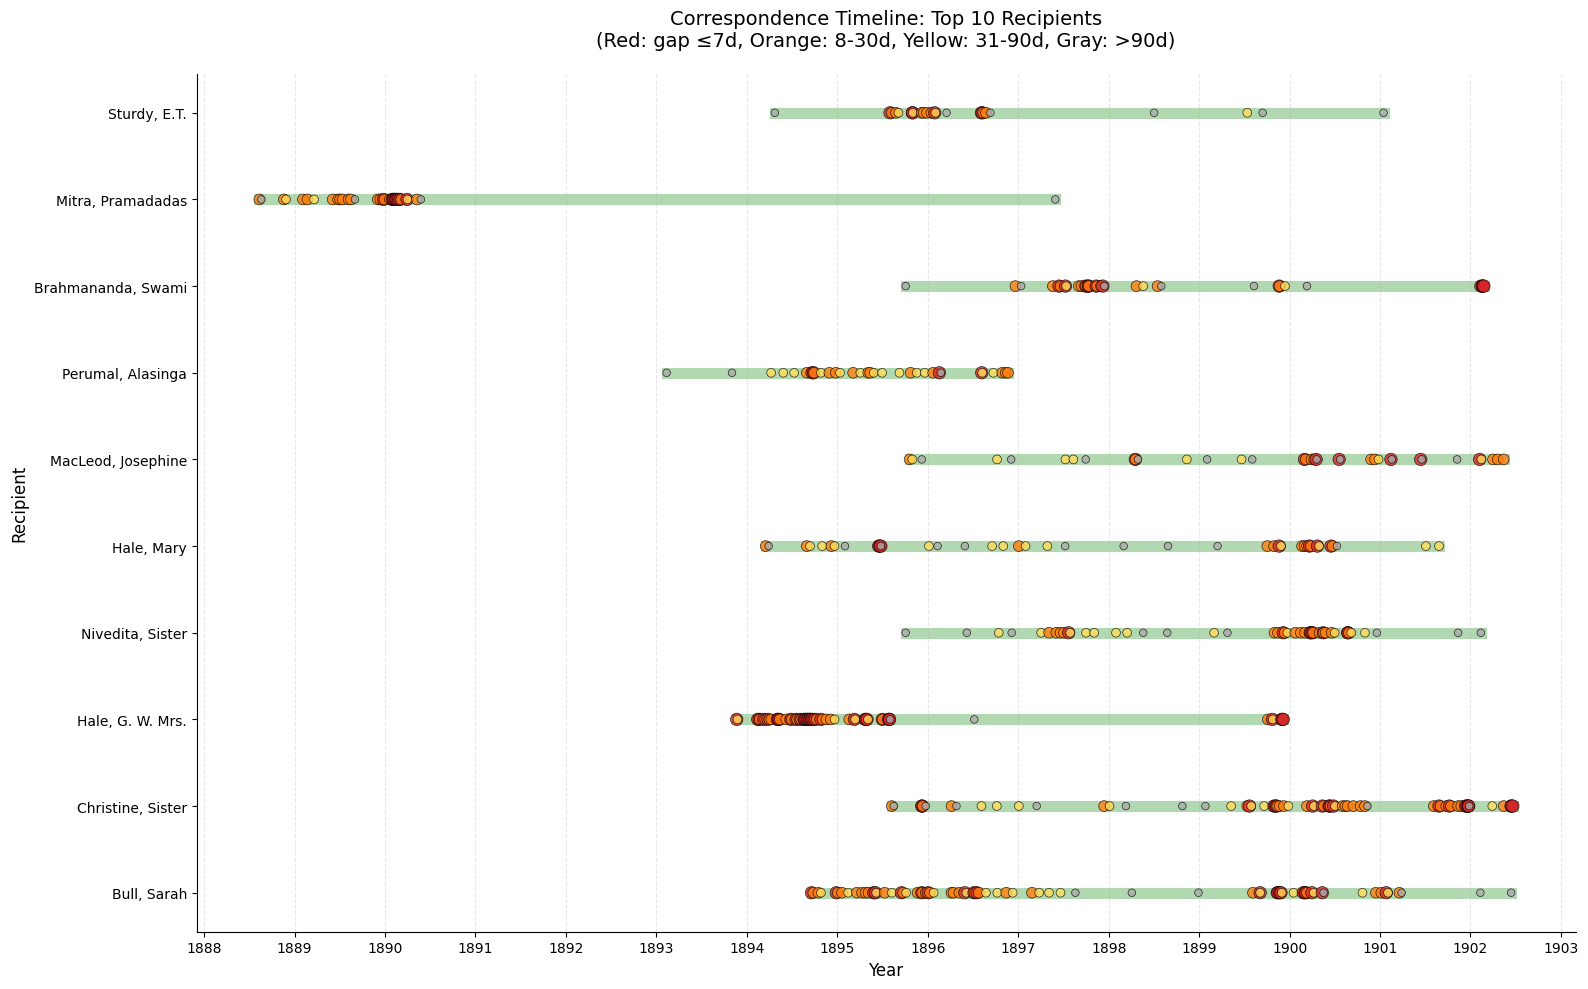

Timeline plot saved


In [3]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

# Timeline visualization with colored dots and correspondence time bracket
fig, ax = plt.subplots(figsize=(16, 10))

top_recipients = df_clean['Audience'].value_counts().head(10).index
df_sorted = df_clean.sort_values('Date_parsed')

for i, recipient in enumerate(top_recipients):
    recipient_letters = df_sorted[df_sorted['Audience'] == recipient]['Date_parsed'].dropna().reset_index(drop=True)

    if len(recipient_letters) > 0:
        # Draw thick green line from first to last letter
        first_date = recipient_letters.iloc[0]
        last_date = recipient_letters.iloc[-1]
        ax.plot([first_date, last_date], [i, i], color='green', linewidth=8, alpha=0.3, zorder=1)

        colors = []
        sizes = []

        for j in range(len(recipient_letters)):
            if j < len(recipient_letters) - 1:
                # Calculate gap to next letter
                gap_days = (recipient_letters.iloc[j + 1] - recipient_letters.iloc[j]).days

                # Color based on gap size
                if gap_days <= 7:
                    colors.append('#d62728')  # red - short gap (high frequency)
                    sizes.append(80)
                elif gap_days <= 30:
                    colors.append('#ff7f0e')  # orange - medium gap
                    sizes.append(60)
                elif gap_days <= 90:
                    colors.append('#ffdd57')  # yellow - long gap
                    sizes.append(40)
                else:
                    colors.append('#aaaaaa')  # gray - very long gap
                    sizes.append(30)
            else:
                # Last letter - use same coloring logic based on previous gap
                if j > 0:
                    prev_gap = (recipient_letters.iloc[j] - recipient_letters.iloc[j-1]).days
                    if prev_gap <= 7:
                        colors.append('#d62728')
                        sizes.append(80)
                    elif prev_gap <= 30:
                        colors.append('#ff7f0e')
                        sizes.append(60)
                    elif prev_gap <= 90:
                        colors.append('#ffdd57')
                        sizes.append(40)
                    else:
                        colors.append('#aaaaaa')
                        sizes.append(30)
                else:
                    colors.append('#aaaaaa')
                    sizes.append(50)

        # Plot letter points with colors
        ax.scatter(recipient_letters, [i] * len(recipient_letters),
                  s=sizes, c=colors, zorder=3, alpha=0.8, edgecolors='black', linewidths=0.5)

# Set y-axis labels
ax.set_yticks(range(len(top_recipients)))
ax.set_yticklabels(top_recipients)

# Format x-axis
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_major_locator(mdates.YearLocator())
plt.xticks(rotation=0)

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Recipient', fontsize=12)
ax.set_title('Correspondence Timeline: Top 10 Recipients\n(Red: gap ≤7d, Orange: 8-30d, Yellow: 31-90d, Gray: >90d)',
             fontsize=14, pad=20)

ax.grid(axis='x', alpha=0.3, linestyle='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
# plt.savefig('/mnt/user-data/outputs/correspondence_timeline.png', dpi=300, bbox_inches='tight')
plt.show()

print("Timeline plot saved")

In [4]:
# Find letters written after long breaks - top 10 by gap size
print("="*80)
print("TOP 10 LETTERS WRITTEN AFTER LONGEST BREAKS")
print("="*80)

df_sorted = df_clean.sort_values('Date_parsed')

long_break_letters = []

for recipient in df_clean['Audience'].value_counts().head(20).index:
    recipient_letters = df_sorted[df_sorted['Audience'] == recipient].copy()
    recipient_letters = recipient_letters[recipient_letters['Date_parsed'].notna()].reset_index(drop=True)

    if len(recipient_letters) > 1:
        for j in range(1, len(recipient_letters)):
            gap_days = (recipient_letters.loc[j, 'Date_parsed'] - recipient_letters.loc[j-1, 'Date_parsed']).days

            long_break_letters.append({
                'recipient': recipient,
                'gap_days': gap_days,
                'previous_date': recipient_letters.loc[j-1, 'Date_parsed'],
                'current_date': recipient_letters.loc[j, 'Date_parsed'],
                'place': recipient_letters.loc[j, 'Place'],
                'language': recipient_letters.loc[j, 'Language'],
                'word_count': recipient_letters.loc[j, 'body_word_count'],
                'url': recipient_letters.loc[j, 'full_url']
            })

# Sort by gap size and take top 10
long_break_df = pd.DataFrame(long_break_letters).sort_values('gap_days', ascending=False).head(10)

for idx, row in long_break_df.iterrows():
    print(f"\n{'='*80}")
    print(f"RECIPIENT: {row['recipient']}")
    print(f"Gap: {row['gap_days']} days ({row['gap_days']/365:.1f} years)")
    print(f"Previous letter: {row['previous_date'].strftime('%Y-%m-%d')}")
    print(f"This letter: {row['current_date'].strftime('%Y-%m-%d')}")
    print(f"Place: {row['place']}, Language: {row['language']}, Words: {row['word_count']}")
    print(f"URL: {row['url']}")

TOP 10 LETTERS WRITTEN AFTER LONGEST BREAKS

RECIPIENT: Mitra, Pramadadas
Gap: 2561 days (7.0 years)
Previous letter: 1890-05-26
This letter: 1897-05-30
Place: India, Almora, Language: Bengali, Words: 914
URL: https://www.ramakrishnavivekananda.info/vivekananda/volume_6/epistles_second_series/124_sir.htm

RECIPIENT: McKindley, Isabelle
Gap: 1407 days (3.9 years)
Previous letter: 1895-10-24
This letter: 1899-08-31
Place: USA, NY, Stone Ridge, Ridgely Manor, Language: English, Words: 110
URL: https://www.ramakrishnavivekananda.info/vivekananda/volume_9/letters_fifth_series/144_isabel.htm

RECIPIENT: Leggett, Francis H
Gap: 1220 days (3.3 years)
Previous letter: 1896-12-13
This letter: 1900-04-17
Place: USA, Language: English, Words: 196
URL: https://www.ramakrishnavivekananda.info/vivekananda/volume_7/epistles_third_series/51_mr_leggett.htm

RECIPIENT: Hale, G. W. Mrs.
Gap: 1185 days (3.2 years)
Previous letter: 1896-07-07
This letter: 1899-10-05
Place: USA, NY, Stone Ridge, Ridgely Mano

In [5]:
print("="*80)
print("MONTHWISE INTENSITY ANALYSIS")
print("="*80)

# Get year-month data
df_clean['Year_Month'] = df_clean['Date_parsed'].dt.to_period('M')
monthly_counts = df_clean['Year_Month'].value_counts().sort_index()

print(f"\nTop 20 most intense months by letter count:\n")
for period, count in monthly_counts.nlargest(20).items():
    month_data = df_clean[df_clean['Year_Month'] == period]
    recipients = month_data['Audience'].value_counts()
    places = month_data['Place'].value_counts()

    print(f"\n{period} - {count} letters")
    print(f"  Top recipients: {', '.join([f'{r} ({c})' for r, c in recipients.head(3).items()])}")
    print(f"  Top places: {', '.join([f'{p} ({c})' for p, c in places.head(3).items()])}")

print("\n" + "="*80)
print("CATEGORY COLUMN ANALYSIS")
print("="*80)

print(f"\nUnique categories: {df_clean['Category'].nunique()}")
print(f"\nCategory distribution:")
print(df_clean['Category'].value_counts())

category_stats = df_clean.groupby('Category').agg({
    'body_word_count': ['mean', 'median', 'count'],
    'Language': lambda x: x.value_counts().to_dict()
}).round(1)

print(f"\nCategory statistics:")
for cat in df_clean['Category'].value_counts().index[:10]:
    cat_data = df_clean[df_clean['Category'] == cat]
    print(f"\n{cat}:")
    print(f"  Count: {len(cat_data)}")
    print(f"  Avg words: {cat_data['body_word_count'].mean():.1f}")
    print(f"  Languages: {cat_data['Language'].value_counts().to_dict()}")
    print(f"  Top recipients: {cat_data['Audience'].value_counts().head(3).to_dict()}")

print("\n" + "="*80)
print("SOURCE COLUMN ANALYSIS")
print("="*80)

print(f"\nUnique sources: {df_clean['Source'].nunique()}")
print(f"\nSource distribution:")
print(df_clean['Source'].value_counts())

print(f"\nSource statistics:")
for source in df_clean['Source'].value_counts().index[:10]:
    source_data = df_clean[df_clean['Source'] == source]
    print(f"\n{source}:")
    print(f"  Count: {len(source_data)}")
    print(f"  Avg words: {source_data['body_word_count'].mean():.1f}")
    print(f"  Top recipients: {source_data['Audience'].value_counts().head(3).to_dict()}")

MONTHWISE INTENSITY ANALYSIS

Top 20 most intense months by letter count:


1894-09 - 19 letters
  Top recipients: Hale, G. W. Mrs. (7), Perumal, Alasinga (3), Bull, Sarah (2)
  Top places: USA, MA, Boston (10), USA (5), USA, NY, New York (1)

1895-12 - 18 letters
  Top recipients: Christine, Sister (4), Sturdy, E.T. (3), Bull, Sarah (3)
  Top places: USA, NY, New York City (13), USA, IL, Chicago (3), R.M.S. Britannic (1)

1899-11 - 17 letters
  Top recipients: Bull, Sarah (5), Christine, Sister (4), Leggett, Francis Mrs. (2)
  Top places: USA, NY, New York City (8), USA, IL, Chicago (3), USA, NY, Stone Ridge, Ridgely Manor (2)

1900-03 - 17 letters
  Top recipients: Hale, Mary (4), Nivedita, Sister (3), Bull, Sarah (3)
  Top places: USA, CA, San Francisco (17)

1900-04 - 17 letters
  Top recipients: MacLeod, Josephine (3), Bull, Sarah (2), Christine, Sister (2)
  Top places: USA, CA, San Francisco (6), USA (4), India, Dacca (Belur) (3)

1897-07 - 15 letters
  Top recipients: Nivedita,

/tmp/ipython-input-1197286475.py:125: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


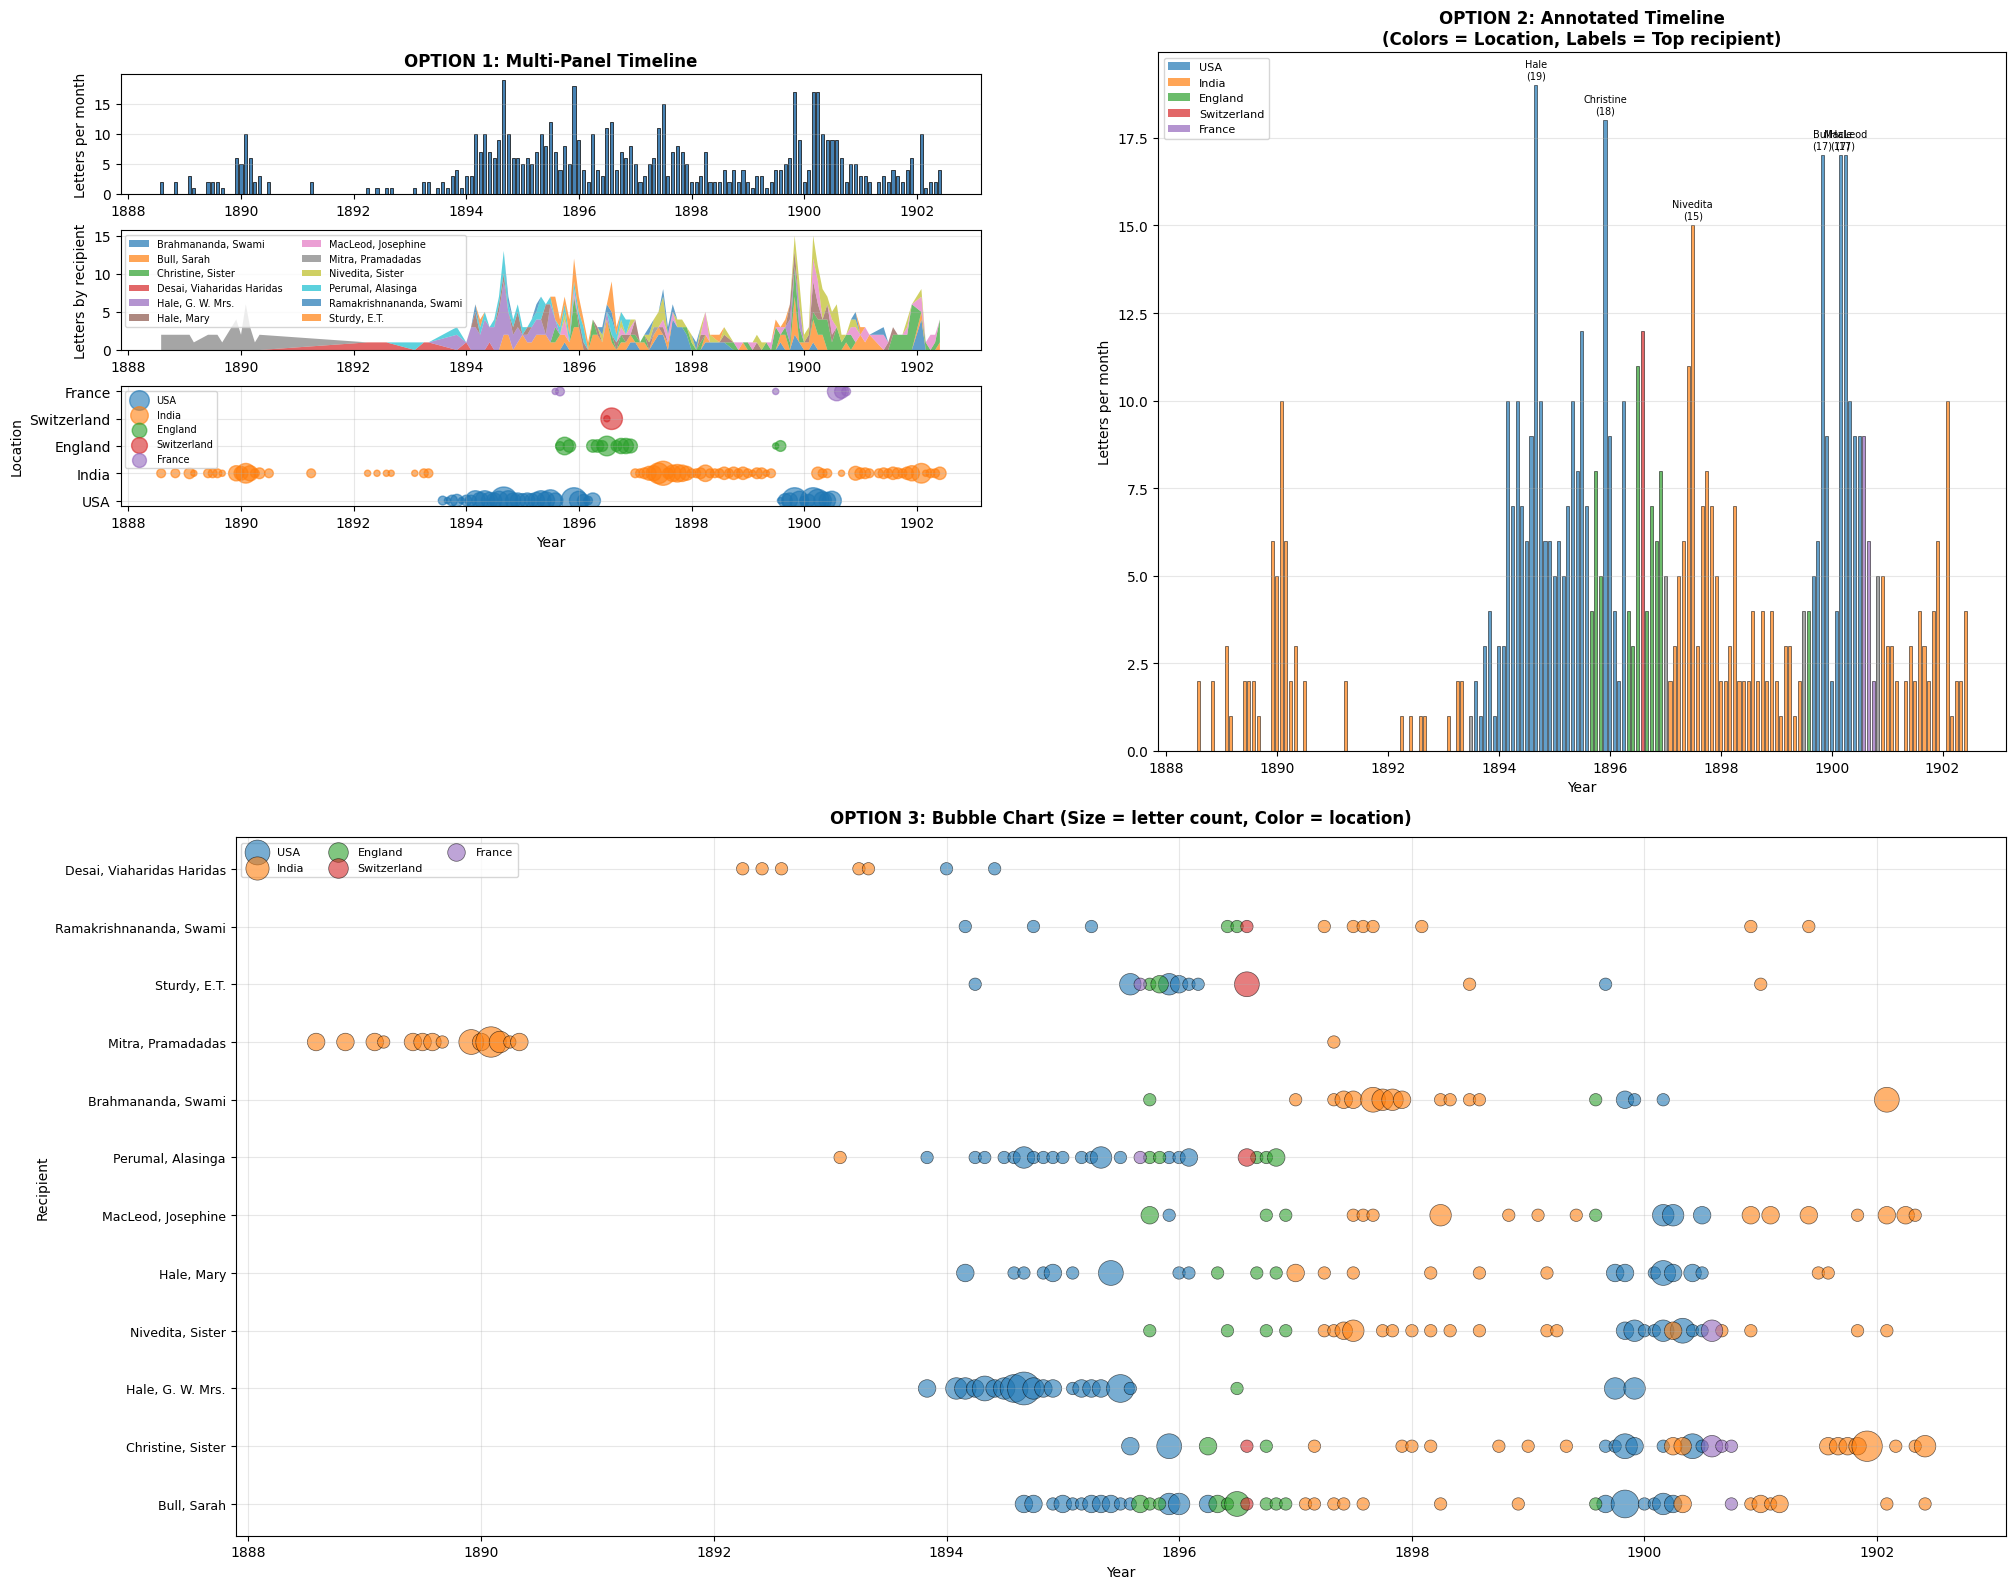

All three visualization options saved


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Prepare data
df_clean['Year_Month'] = df_clean['Date_parsed'].dt.to_period('M')
df_clean['Year_Month_dt'] = df_clean['Date_parsed'].dt.to_period('M').dt.to_timestamp()

# Get top recipients
top_recipients = df_clean['Audience'].value_counts().head(12).index

# Create figure with 3 options
fig = plt.figure(figsize=(20, 16))

# ============================================================================
# OPTION 1: Multi-panel timeline
# ============================================================================
gs1 = fig.add_gridspec(3, 1, left=0.05, right=0.48, top=0.95, bottom=0.68, hspace=0.3)

# Panel 1: Letters per month
ax1 = fig.add_subplot(gs1[0])
monthly_counts = df_clean['Year_Month'].value_counts().sort_index()
monthly_counts.index = monthly_counts.index.to_timestamp()
ax1.bar(monthly_counts.index, monthly_counts.values, width=20, color='steelblue', edgecolor='black', linewidth=0.5)
ax1.set_ylabel('Letters per month', fontsize=10)
ax1.set_title('OPTION 1: Multi-Panel Timeline', fontsize=12, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Panel 2: Stacked area by recipient
ax2 = fig.add_subplot(gs1[1], sharex=ax1)
recipient_monthly = df_clean[df_clean['Audience'].isin(top_recipients)].groupby(['Year_Month', 'Audience']).size().unstack(fill_value=0)
recipient_monthly.index = recipient_monthly.index.to_timestamp()
ax2.stackplot(recipient_monthly.index, *[recipient_monthly[col] for col in recipient_monthly.columns],
              labels=recipient_monthly.columns, alpha=0.7)
ax2.set_ylabel('Letters by recipient', fontsize=10)
ax2.legend(loc='upper left', fontsize=7, ncol=2)
ax2.grid(axis='y', alpha=0.3)

# Panel 3: Geographic location
ax3 = fig.add_subplot(gs1[2], sharex=ax1)
location_map = {'USA': 0, 'India': 1, 'England': 2, 'Switzerland': 3, 'France': 4}
df_clean['location_code'] = df_clean['Place'].apply(lambda x: str(x).split(',')[0] if pd.notna(x) else 'Unknown')
location_monthly = df_clean.groupby(['Year_Month_dt', 'location_code']).size().reset_index(name='count')
for location in ['USA', 'India', 'England', 'Switzerland', 'France']:
    loc_data = location_monthly[location_monthly['location_code'] == location]
    ax3.scatter(loc_data['Year_Month_dt'], [location_map.get(location, 5)] * len(loc_data),
               s=loc_data['count']*20, alpha=0.6, label=location)
ax3.set_yticks(list(location_map.values()))
ax3.set_yticklabels(list(location_map.keys()))
ax3.set_ylabel('Location', fontsize=10)
ax3.set_xlabel('Year', fontsize=10)
ax3.legend(loc='upper left', fontsize=7)
ax3.grid(alpha=0.3)

# ============================================================================
# OPTION 2: Annotated timeline
# ============================================================================
ax4 = fig.add_subplot(2, 2, 2)
monthly_agg = df_clean.groupby('Year_Month').agg({
    'Audience': lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[0],
    'Place': lambda x: str(x.mode()[0]).split(',')[0] if len(x.mode()) > 0 and pd.notna(x.mode()[0]) else 'Unknown'
}).reset_index()
monthly_agg['count'] = df_clean['Year_Month'].value_counts().sort_index().values
monthly_agg['Year_Month_dt'] = monthly_agg['Year_Month'].dt.to_timestamp()

color_map = {'USA': '#1f77b4', 'India': '#ff7f0e', 'England': '#2ca02c',
             'Switzerland': '#d62728', 'France': '#9467bd', 'Unknown': '#7f7f7f'}
colors = [color_map.get(loc, '#7f7f7f') for loc in monthly_agg['Place']]

ax4.bar(monthly_agg['Year_Month_dt'], monthly_agg['count'], width=20, color=colors,
        edgecolor='black', linewidth=0.5, alpha=0.7)

# Annotate peaks (>12 letters)
for idx, row in monthly_agg[monthly_agg['count'] > 12].iterrows():
    ax4.annotate(f"{row['Audience'].split(',')[0]}\n({row['count']})",
                xy=(row['Year_Month_dt'], row['count']),
                xytext=(0, 5), textcoords='offset points',
                fontsize=7, ha='center', rotation=0)

ax4.set_ylabel('Letters per month', fontsize=10)
ax4.set_xlabel('Year', fontsize=10)
ax4.set_title('OPTION 2: Annotated Timeline\n(Colors = Location, Labels = Top recipient)',
              fontsize=12, fontweight='bold')
ax4.grid(axis='y', alpha=0.3)

# Legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=color_map[loc], label=loc, alpha=0.7)
                  for loc in ['USA', 'India', 'England', 'Switzerland', 'France']]
ax4.legend(handles=legend_elements, loc='upper left', fontsize=8)

# ============================================================================
# OPTION 3: Bubble chart
# ============================================================================
ax5 = fig.add_subplot(2, 1, 2)

bubble_data = df_clean[df_clean['Audience'].isin(top_recipients)].copy()
bubble_agg = bubble_data.groupby(['Year_Month_dt', 'Audience']).agg({
    'Place': lambda x: str(x.mode()[0]).split(',')[0] if len(x.mode()) > 0 and pd.notna(x.mode()[0]) else 'Unknown',
    'Audience': 'size'
}).rename(columns={'Audience': 'count'}).reset_index()

# Map recipients to y-positions
recipient_order = {r: i for i, r in enumerate(top_recipients)}
bubble_agg['y_pos'] = bubble_agg['Audience'].map(recipient_order)

# Plot bubbles
for location, color in color_map.items():
    loc_data = bubble_agg[bubble_agg['Place'] == location]
    if len(loc_data) > 0:
        ax5.scatter(loc_data['Year_Month_dt'], loc_data['y_pos'],
                   s=loc_data['count']*80, c=color, alpha=0.6,
                   edgecolors='black', linewidths=0.5, label=location)

ax5.set_yticks(range(len(top_recipients)))
ax5.set_yticklabels(top_recipients, fontsize=9)
ax5.set_xlabel('Year', fontsize=10)
ax5.set_ylabel('Recipient', fontsize=10)
ax5.set_title('OPTION 3: Bubble Chart (Size = letter count, Color = location)',
              fontsize=12, fontweight='bold', pad=10)
ax5.grid(alpha=0.3)
ax5.legend(loc='upper left', fontsize=8, ncol=3)

plt.tight_layout()
# plt.savefig('/mnt/user-data/outputs/monthwise_visualizations_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("All three visualization options saved")

SYNTACTIC ANALYSIS OF EDITORIAL REDACTIONS

1️⃣ REDACTION TOKEN EXTRACTION
--------------------------------------------------------------------------------
Total redaction tokens found: 13
Unique redaction forms: 4

All redaction forms by frequency:
full_token
A__    10
S__     1
X__     1
M__     1
Name: count, dtype: int64

Redaction forms by initial:
initial
A    10
S     1
X     1
M     1
Name: count, dtype: int64

2️⃣ UNDERSCORE LENGTH ANALYSIS
--------------------------------------------------------------------------------

Underscore count statistics:
count    13.0
mean      2.0
std       0.0
min       2.0
25%       2.0
50%       2.0
75%       2.0
max       2.0
Name: underscore_count, dtype: float64

Underscore count distribution:
underscore_count
2    13
Name: count, dtype: int64

Underscore count by initial letter:
  A: mean=2.00, std=0.00, min=2, max=2, count=10
  S: mean=2.00, std=nan, min=2, max=2, count=1
  X: mean=2.00, std=nan, min=2, max=2, count=1
  M: mean=2.00, std=n

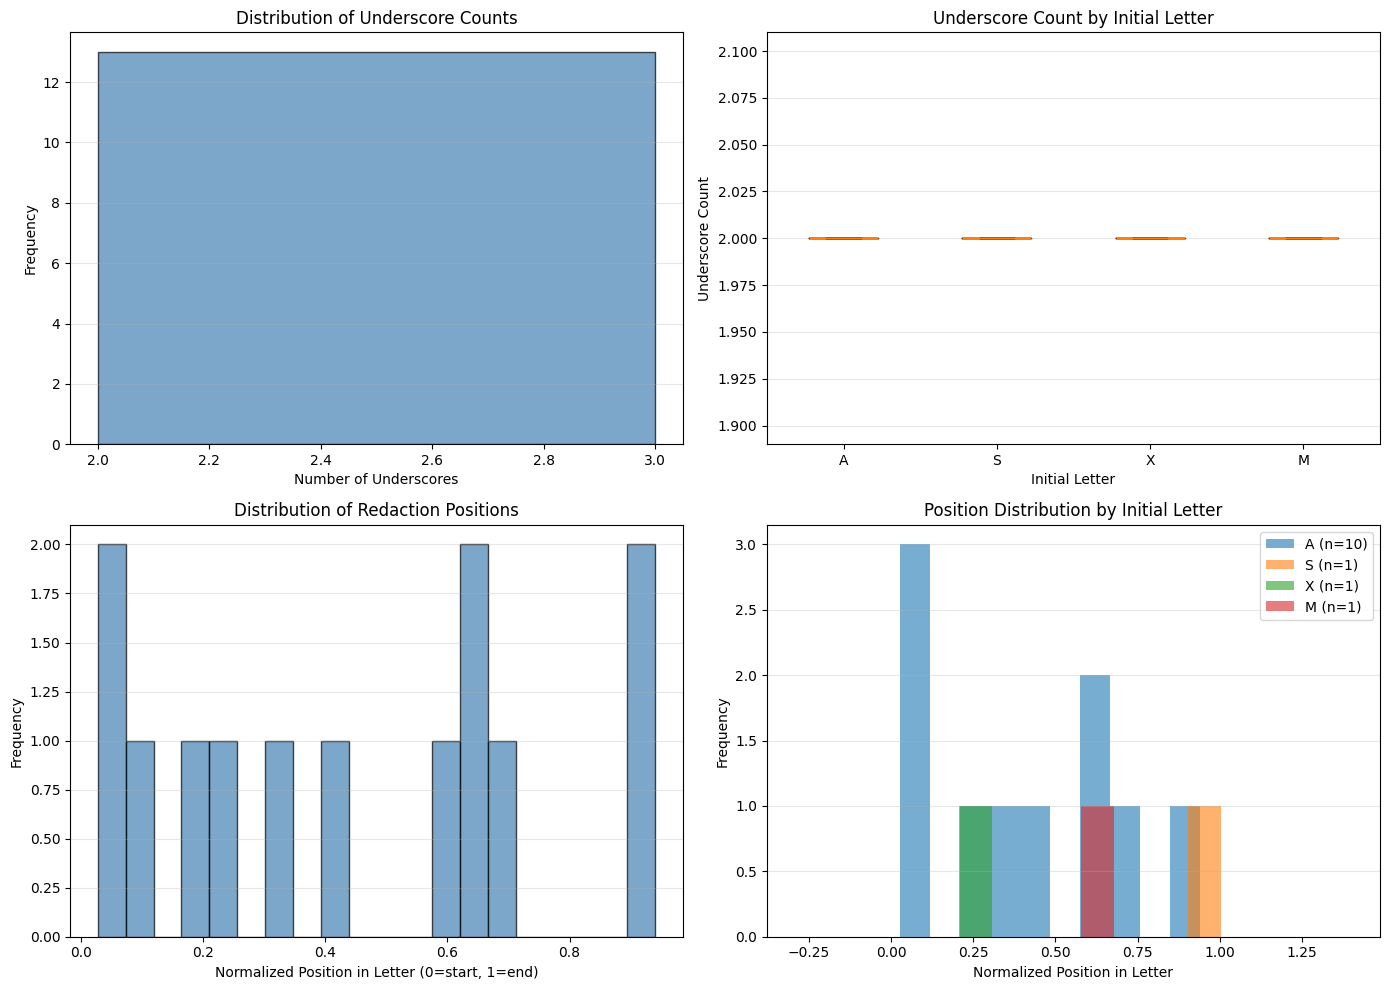


5️⃣ FORMAL CONTEXT ANALYSIS
--------------------------------------------------------------------------------

Left punctuation frequency:
  '': 7
  '.': 5
  '"': 1

Right punctuation frequency:
  '': 6
  '.': 4
  '!': 2
  ',': 1

Left token frequency:
  'from': 2
  'as': 1
  'sorry': 1
  'Mrs': 1
  'vision': 1
  'of': 1
  'off': 1
  'to': 1
  'with': 1
  'that': 1
  'this': 1
  'Now': 1

Right token frequency:
  'is': 2
  'has': 2
  'and': 1
  'Babu': 1
  'He': 1
  'that': 1
  'stating': 1
  'I': 1
  'wanted': 1
  'business': 1
  'disturbs': 1

Contextual patterns:
  In parentheses: 0 (0.0%)
  Near sentence boundary: 3 (23.1%)
  After title: 1 (7.7%)

ANALYSIS COMPLETE


In [11]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter

print("="*80)
print("SYNTACTIC ANALYSIS OF EDITORIAL REDACTIONS")
print("="*80)

# ============================================================================
# 1️⃣ REDACTION TOKEN EXTRACTION
# ============================================================================
print("\n1️⃣ REDACTION TOKEN EXTRACTION")
print("-"*80)

# Pattern to match redactions: capital letter(s) followed by underscores
redaction_pattern = r'\b([A-Z](?:\.[A-Z])*)(_{2,})\b'

redaction_data = []

for idx, row in df_clean.iterrows():
    text = str(row['body_text']) if pd.notna(row['body_text']) else ''
    matches = re.finditer(redaction_pattern, text)

    for match in matches:
        full_token = match.group(0)
        initial = match.group(1)
        underscores = match.group(2)
        year_val = row['Year'] if 'Year' in row and pd.notna(row['Year']) else None

        redaction_data.append({
            'letter_idx': idx,
            'full_token': full_token,
            'initial': initial,
            'underscore_count': len(underscores),
            'recipient': row['Audience'],
            'year': year_val,
            'position_in_text': match.start() / len(text) if len(text) > 0 else 0
        })

redaction_df = pd.DataFrame(redaction_data)

if len(redaction_df) == 0:
    print("NO REDACTIONS FOUND IN DATASET")
    print("\nThis suggests either:")
    print("  - No editorial redactions exist in the preserved letters")
    print("  - Redactions use a different encoding system")
    print("  - Text extraction did not preserve redaction markers")
else:
    print(f"Total redaction tokens found: {len(redaction_df)}")
    print(f"Unique redaction forms: {redaction_df['full_token'].nunique()}")
    print(f"\nAll redaction forms by frequency:")
    print(redaction_df['full_token'].value_counts())

    print(f"\nRedaction forms by initial:")
    print(redaction_df['initial'].value_counts())

# ============================================================================
# 2️⃣ UNDERSCORE LENGTH ANALYSIS
# ============================================================================
if len(redaction_df) > 0:
    print("\n2️⃣ UNDERSCORE LENGTH ANALYSIS")
    print("-"*80)

    print(f"\nUnderscore count statistics:")
    print(redaction_df['underscore_count'].describe())

    print(f"\nUnderscore count distribution:")
    print(redaction_df['underscore_count'].value_counts().sort_index())

    print(f"\nUnderscore count by initial letter:")
    for initial in redaction_df['initial'].unique():
        initial_data = redaction_df[redaction_df['initial'] == initial]['underscore_count']
        print(f"  {initial}: mean={initial_data.mean():.2f}, std={initial_data.std():.2f}, "
              f"min={initial_data.min()}, max={initial_data.max()}, count={len(initial_data)}")

    # Visualizations
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Histogram of underscore counts
    underscore_range = range(redaction_df['underscore_count'].min(),
                            redaction_df['underscore_count'].max()+2)
    axes[0, 0].hist(redaction_df['underscore_count'], bins=underscore_range,
                    color='steelblue', edgecolor='black', alpha=0.7)
    axes[0, 0].set_xlabel('Number of Underscores')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('Distribution of Underscore Counts')
    axes[0, 0].grid(axis='y', alpha=0.3)

    # Boxplot by initial letter
    initials = redaction_df['initial'].unique()
    boxplot_data = [redaction_df[redaction_df['initial'] == init]['underscore_count'].values
                    for init in initials]
    axes[0, 1].boxplot(boxplot_data, tick_labels=initials)
    axes[0, 1].set_xlabel('Initial Letter')
    axes[0, 1].set_ylabel('Underscore Count')
    axes[0, 1].set_title('Underscore Count by Initial Letter')
    axes[0, 1].grid(axis='y', alpha=0.3)

    # ============================================================================
    # 3️⃣ CONSISTENCY & REUSE ANALYSIS
    # ============================================================================
    print("\n3️⃣ CONSISTENCY & REUSE ANALYSIS")
    print("-"*80)

    reuse_analysis = redaction_df.groupby('full_token').agg({
        'letter_idx': ['count', lambda x: x.nunique()],
        'year': [lambda x: f"{x.min():.0f}-{x.max():.0f}" if x.notna().any() else 'N/A'],
        'recipient': [lambda x: x.nunique()]
    })
    reuse_analysis.columns = ['frequency', 'num_letters', 'year_span', 'num_recipients']
    reuse_analysis = reuse_analysis.sort_values('frequency', ascending=False).reset_index()

    print("\nAll redaction forms with reuse statistics:")
    print(reuse_analysis.to_string())

    print(f"\nRedaction forms appearing in multiple letters: {(reuse_analysis['num_letters'] > 1).sum()}")
    print(f"Redaction forms appearing with multiple recipients: {(reuse_analysis['num_recipients'] > 1).sum()}")

    # ============================================================================
    # 4️⃣ POSITIONAL SYNTAX ANALYSIS
    # ============================================================================
    print("\n4️⃣ POSITIONAL SYNTAX ANALYSIS")
    print("-"*80)

    print(f"\nPosition statistics (0=start, 1=end):")
    print(redaction_df['position_in_text'].describe())

    # Histogram of positions
    axes[1, 0].hist(redaction_df['position_in_text'], bins=20, color='steelblue',
                    edgecolor='black', alpha=0.7)
    axes[1, 0].set_xlabel('Normalized Position in Letter (0=start, 1=end)')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('Distribution of Redaction Positions')
    axes[1, 0].grid(axis='y', alpha=0.3)

    # Position distribution by initial
    for initial in initials:
        initial_positions = redaction_df[redaction_df['initial'] == initial]['position_in_text']
        if len(initial_positions) > 0:
            axes[1, 1].hist(initial_positions, bins=10, alpha=0.6, label=f"{initial} (n={len(initial_positions)})")
    axes[1, 1].set_xlabel('Normalized Position in Letter')
    axes[1, 1].set_ylabel('Frequency')
    axes[1, 1].set_title('Position Distribution by Initial Letter')
    axes[1, 1].legend()
    axes[1, 1].grid(axis='y', alpha=0.3)

    plt.tight_layout()
    # plt.savefig('/mnt/user-data/outputs/redaction_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    # ============================================================================
    # 5️⃣ FORMAL CONTEXT (NON-SEMANTIC)
    # ============================================================================
    print("\n5️⃣ FORMAL CONTEXT ANALYSIS")
    print("-"*80)

    context_data = {
        'left_token': [],
        'right_token': [],
        'left_punct': [],
        'right_punct': [],
        'in_parentheses': [],
        'near_sentence_boundary': [],
        'after_title': []
    }

    titles = ['Mr.', 'Mrs.', 'Miss', 'Dr.', 'Swami', 'Raja', 'Maharaja', 'Sri', 'Shri']

    for idx, row in df_clean.iterrows():
        text = str(row['body_text']) if pd.notna(row['body_text']) else ''
        matches = list(re.finditer(redaction_pattern, text))

        for match in matches:
            start = match.start()
            end = match.end()

            # Get left context (20 chars before)
            left_ctx = text[max(0, start-20):start]
            # Get right context (20 chars after)
            right_ctx = text[end:min(len(text), end+20)]

            # Left/right tokens
            left_words = re.findall(r'\b\w+\b', left_ctx)
            right_words = re.findall(r'\b\w+\b', right_ctx)
            context_data['left_token'].append(left_words[-1] if left_words else '')
            context_data['right_token'].append(right_words[0] if right_words else '')

            # Punctuation
            left_punct = re.findall(r'[.,;:!?\(\)\[\]"\']', left_ctx)
            right_punct = re.findall(r'[.,;:!?\(\)\[\]"\']', right_ctx)
            context_data['left_punct'].append(left_punct[-1] if left_punct else '')
            context_data['right_punct'].append(right_punct[0] if right_punct else '')

            # In parentheses
            context_data['in_parentheses'].append('(' in left_ctx and ')' in right_ctx)

            # Near sentence boundary
            boundary_ctx = text[max(0, start-5):start]
            context_data['near_sentence_boundary'].append(any(p in boundary_ctx for p in ['.', '!', '?']))

            # After title
            context_data['after_title'].append(any(title in left_ctx for title in titles))

    context_df = pd.DataFrame(context_data)

    print(f"\nLeft punctuation frequency:")
    left_punct_counts = Counter(context_df['left_punct'])
    for punct, count in left_punct_counts.most_common(10):
        print(f"  '{punct}': {count}")

    print(f"\nRight punctuation frequency:")
    right_punct_counts = Counter(context_df['right_punct'])
    for punct, count in right_punct_counts.most_common(10):
        print(f"  '{punct}': {count}")

    print(f"\nLeft token frequency:")
    left_token_counts = Counter(context_df['left_token'])
    for token, count in left_token_counts.most_common(15):
        print(f"  '{token}': {count}")

    print(f"\nRight token frequency:")
    right_token_counts = Counter(context_df['right_token'])
    for token, count in right_token_counts.most_common(15):
        print(f"  '{token}': {count}")

    print(f"\nContextual patterns:")
    print(f"  In parentheses: {context_df['in_parentheses'].sum()} ({context_df['in_parentheses'].sum()/len(context_df)*100:.1f}%)")
    print(f"  Near sentence boundary: {context_df['near_sentence_boundary'].sum()} ({context_df['near_sentence_boundary'].sum()/len(context_df)*100:.1f}%)")
    print(f"  After title: {context_df['after_title'].sum()} ({context_df['after_title'].sum()/len(context_df)*100:.1f}%)")

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)

TARGETED TRIANGULATION ANALYSIS: A__ REDACTIONS
Testing candidates: Abhedananda, Alasinga, Adams

[1] EXTRACTING A__ REDACTION EVENTS
--------------------------------------------------------------------------------
Total A__ occurrences: 10
Documents with A__: 5

Years with A__: [1899, 1900]

Recipients with A__:
  MacLeod, Josephine: 5
  Bull, Sarah: 3
  Leggett, Francis H: 1
  Leggett, Francis Mrs.: 1

Contextual samples (first 5):

  [1] ...t?

I leave here tonight. These lines in haste as A__ is waiting. Mrs. Adams is kind as usual. Margot d...

  [2] ...rom.

I am only a man, your child.

I am so sorry A__ has made disturbances. He does that now and then,...

  [3] ...ull

DEAR DHIRA MATA,

Here is a long letter from A__. He seems to be entirely upset. I am sure a littl...

  [4] ...Detroit.

Of course by that time you will be off. A__ has done good work so far; and, of course, you kn...

  [5] ...labaloo over it this time.

PS. Did you reveal to A__ that I have given over to you 

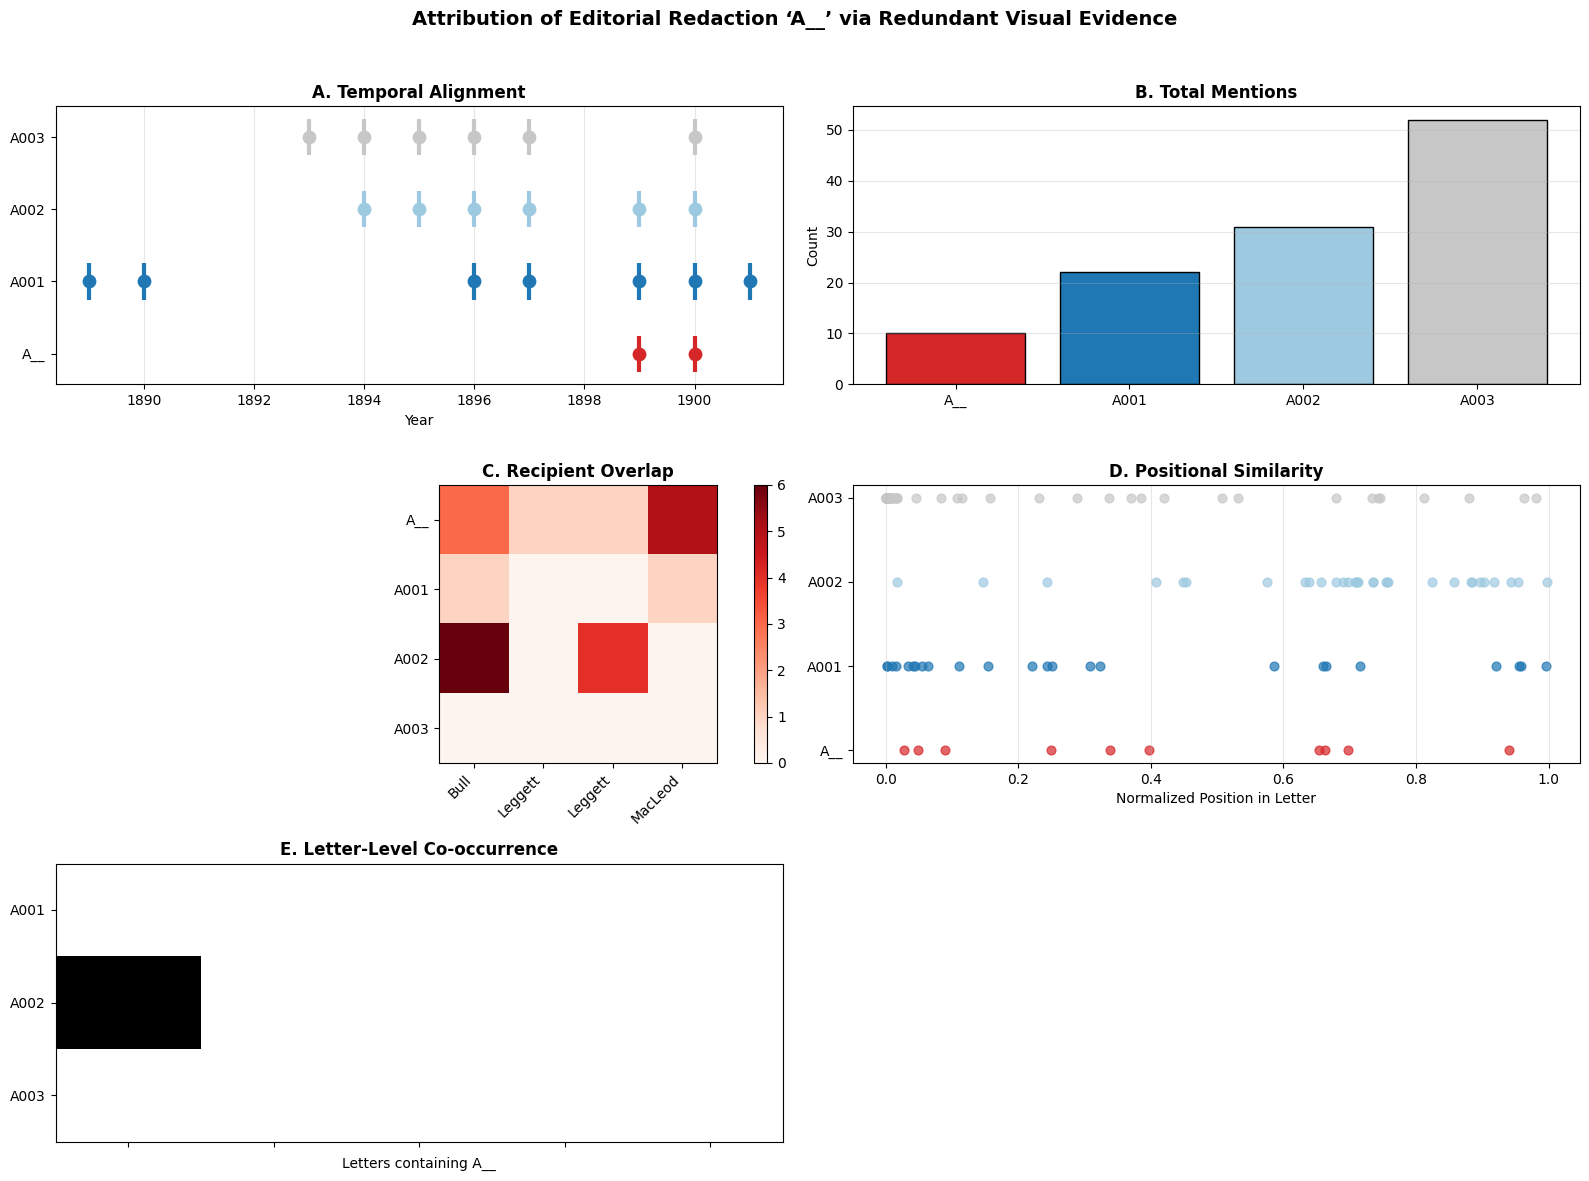

In [17]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

print("="*80)
print("TARGETED TRIANGULATION ANALYSIS: A__ REDACTIONS")
print("Testing candidates: Abhedananda, Alasinga, Adams")
print("="*80)

# ============================================================================
# STEP 1: EXTRACT REDACTION EVENTS (A__ only)
# ============================================================================
print("\n[1] EXTRACTING A__ REDACTION EVENTS")
print("-"*80)

redaction_events = []
for idx, row in df_clean.iterrows():
    text = str(row['body_text']) if pd.notna(row['body_text']) else ''
    year_val = row['Year'] if 'Year' in row and pd.notna(row['Year']) else None
    recipient = row['Audience'] if pd.notna(row['Audience']) else 'Unknown'

    matches = list(re.finditer(r'\bA__\b', text))

    for match in matches:
        position = match.start() / len(text) if len(text) > 0 else 0.5

        # Extract context (50 chars before and after)
        start = max(0, match.start() - 50)
        end = min(len(text), match.end() + 50)
        context = text[start:end]

        redaction_events.append({
            'doc_id': idx,
            'year': year_val,
            'recipient': recipient,
            'position': position,
            'context': context,
            'token': 'A__'
        })

redaction_df = pd.DataFrame(redaction_events)
print(f"Total A__ occurrences: {len(redaction_df)}")
print(f"Documents with A__: {redaction_df['doc_id'].nunique()}")

if len(redaction_df) > 0:
    print(f"\nYears with A__: {sorted([int(y) for y in redaction_df['year'].dropna().unique()])}")
    print(f"\nRecipients with A__:")
    for recipient, count in redaction_df['recipient'].value_counts().items():
        print(f"  {recipient}: {count}")

    print(f"\nContextual samples (first 5):")
    for i, context in enumerate(redaction_df['context'].head(5)):
        print(f"\n  [{i+1}] ...{context}...")

# ============================================================================
# STEP 2: EXTRACT TARGET CANDIDATES
# ============================================================================
print("\n\n[2] EXTRACTING TARGET CANDIDATES")
print("-"*80)

target_candidates = ['Abhedananda', 'Alasinga', 'Adams']

candidate_events = []
for idx, row in df_clean.iterrows():
    text = str(row['body_text']) if pd.notna(row['body_text']) else ''
    year_val = row['Year'] if 'Year' in row and pd.notna(row['Year']) else None
    recipient = row['Audience'] if pd.notna(row['Audience']) else 'Unknown'

    for candidate in target_candidates:
        # Find all occurrences (case-insensitive)
        pattern = r'\b' + re.escape(candidate) + r'\b'
        matches = list(re.finditer(pattern, text, re.IGNORECASE))

        for match in matches:
            position = match.start() / len(text) if len(text) > 0 else 0.5

            # Extract context
            start = max(0, match.start() - 50)
            end = min(len(text), match.end() + 50)
            context = text[start:end]

            candidate_events.append({
                'doc_id': idx,
                'year': year_val,
                'recipient': recipient,
                'position': position,
                'candidate': candidate,
                'context': context
            })

candidate_df = pd.DataFrame(candidate_events)

print(f"\nTotal candidate occurrences: {len(candidate_df)}")
for candidate in target_candidates:
    cand_data = candidate_df[candidate_df['candidate'] == candidate]
    print(f"\n{candidate}:")
    print(f"  Total occurrences: {len(cand_data)}")
    print(f"  Documents: {cand_data['doc_id'].nunique()}")
    if len(cand_data) > 0:
        print(f"  Years: {sorted([int(y) for y in cand_data['year'].dropna().unique()])}")
        print(f"  Recipients: {cand_data['recipient'].value_counts().head(5).to_dict()}")

# ============================================================================
# STEP 3: AGGREGATE STATISTICS
# ============================================================================
print("\n\n[3] DETAILED STATISTICS BY CANDIDATE")
print("-"*80)

candidate_stats = {}
for candidate in target_candidates:
    cand_data = candidate_df[candidate_df['candidate'] == candidate]

    if len(cand_data) > 0:
        candidate_stats[candidate] = {
            'years': set(cand_data['year'].dropna().astype(int)),
            'recipients': set(cand_data['recipient']),
            'positions': cand_data['position'].values,
            'yearly_counts': cand_data.groupby('year').size().to_dict(),
            'recipient_counts': cand_data.groupby('recipient').size().to_dict(),
            'doc_count': cand_data['doc_id'].nunique(),
            'total_occurrences': len(cand_data)
        }
    else:
        candidate_stats[candidate] = {
            'years': set(),
            'recipients': set(),
            'positions': np.array([]),
            'yearly_counts': {},
            'recipient_counts': {},
            'doc_count': 0,
            'total_occurrences': 0
        }

# ============================================================================
# STEP 4: ALIGNMENT SCORING
# ============================================================================
print("\n[4] COMPUTING ALIGNMENT SCORES")
print("-"*80)

if len(redaction_df) == 0:
    print("No A__ redactions found - cannot compute alignment")
else:
    redaction_years = set(redaction_df['year'].dropna().astype(int))
    redaction_recipients = set(redaction_df['recipient'])
    redaction_positions = redaction_df['position'].values
    redaction_year_counts = redaction_df.groupby('year').size().to_dict()
    redaction_recipient_counts = redaction_df.groupby('recipient').size().to_dict()

    alignment_results = []

    for candidate in target_candidates:
        stats = candidate_stats[candidate]

        # Temporal overlap (Jaccard)
        year_intersection = len(stats['years'] & redaction_years)
        year_union = len(stats['years'] | redaction_years)
        temporal_overlap = year_intersection / year_union if year_union > 0 else 0

        # Recipient overlap (Jaccard)
        recip_intersection = len(stats['recipients'] & redaction_recipients)
        recip_union = len(stats['recipients'] | redaction_recipients)
        recipient_overlap = recip_intersection / recip_union if recip_union > 0 else 0

        # Positional similarity
        if len(stats['positions']) > 0 and len(redaction_positions) > 0:
            cand_mean_pos = np.mean(stats['positions'])
            redact_mean_pos = np.mean(redaction_positions)
            pos_diff = abs(cand_mean_pos - redact_mean_pos)
            positional_similarity = 1 - pos_diff
        else:
            positional_similarity = 0

        # Frequency correlation (year-wise)
        common_years = stats['years'] & redaction_years
        if len(common_years) >= 2:
            cand_freq = [stats['yearly_counts'].get(y, 0) for y in sorted(common_years)]
            redact_freq = [redaction_year_counts.get(y, 0) for y in sorted(common_years)]
            freq_correlation = np.corrcoef(cand_freq, redact_freq)[0, 1] if len(cand_freq) > 1 else 0
        else:
            freq_correlation = 0

        # Weighted alignment score
        alignment_score = (
            0.35 * temporal_overlap +
            0.35 * recipient_overlap +
            0.15 * positional_similarity +
            0.15 * max(0, freq_correlation)
        )

        alignment_results.append({
            'candidate': candidate,
            'temporal_overlap': temporal_overlap,
            'recipient_overlap': recipient_overlap,
            'positional_similarity': positional_similarity,
            'freq_correlation': freq_correlation,
            'alignment_score': alignment_score,
            'shared_years': len(stats['years'] & redaction_years),
            'shared_recipients': len(stats['recipients'] & redaction_recipients),
            'doc_count': stats['doc_count'],
            'occurrences': stats['total_occurrences']
        })

    alignment_df = pd.DataFrame(alignment_results).sort_values('alignment_score', ascending=False)

    print("\nALIGNMENT SCORES (sorted by alignment score):")
    print("="*80)
    print(alignment_df.to_string(index=False))

    print("\n\nDETAILED COMPARISON:")
    print("="*80)
    for _, row in alignment_df.iterrows():
        candidate = row['candidate']
        stats = candidate_stats[candidate]
        print(f"\n{candidate}:")
        print(f"  Alignment Score: {row['alignment_score']:.3f}")
        print(f"  Temporal Overlap: {row['temporal_overlap']:.3f} ({row['shared_years']} shared years)")
        print(f"  Recipient Overlap: {row['recipient_overlap']:.3f} ({row['shared_recipients']} shared recipients)")
        print(f"  Positional Similarity: {row['positional_similarity']:.3f}")
        print(f"  Frequency Correlation: {row['freq_correlation']:.3f}")
        print(f"  Shared years: {sorted(stats['years'] & redaction_years)}")
        print(f"  Shared recipients: {sorted(stats['recipients'] & redaction_recipients)}")

# =============================================================================
# FINAL ATTRIBUTION FIGURE — A__ REDACTION
# =============================================================================

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# -----------------------------
# Candidate renaming
# -----------------------------
rename_map = {
    'Abhedananda': 'A001',
    'Adams': 'A002',
    'Alasinga': 'A003'
}

# Colors
COL = {
    'A__': '#d62728',
    'A001': '#1f77b4',
    'A002': '#9ecae1',
    'A003': '#c7c7c7'
}

# -----------------------------
# Prepare data
# -----------------------------
candidates = ['Abhedananda', 'Adams', 'Alasinga']
labels = ['A__', 'A001', 'A002', 'A003']

# Years
year_data = {
    'A__': sorted(redaction_year_counts),
    'A001': sorted(candidate_stats['Abhedananda']['yearly_counts']),
    'A002': sorted(candidate_stats['Adams']['yearly_counts']),
    'A003': sorted(candidate_stats['Alasinga']['yearly_counts'])
}

# Frequencies
freq_data = {
    'A__': redaction_year_counts,
    'A001': candidate_stats['Abhedananda']['yearly_counts'],
    'A002': candidate_stats['Adams']['yearly_counts'],
    'A003': candidate_stats['Alasinga']['yearly_counts']
}

# Recipients
recipients = sorted(set(redaction_recipients))
heatmap = []
heatmap.append([redaction_recipient_counts.get(r, 0) for r in recipients])
for c in candidates:
    heatmap.append([candidate_stats[c]['recipient_counts'].get(r, 0) for r in recipients])
heatmap = np.array(heatmap)

# Positions
positions = {
    'A__': redaction_positions,
    'A001': candidate_stats['Abhedananda']['positions'],
    'A002': candidate_stats['Adams']['positions'],
    'A003': candidate_stats['Alasinga']['positions']
}

# Letter-level co-occurrence
letters = sorted(set(redaction_df['doc_id']))
co_matrix = []
for lab, cand in zip(labels[1:], candidates):
    row = []
    cand_docs = set(candidate_df[candidate_df['candidate'] == cand]['doc_id'])
    for d in letters:
        row.append(int(d in cand_docs))
    co_matrix.append(row)
co_matrix = np.array(co_matrix)

# -----------------------------
# Plot
# -----------------------------
fig = plt.figure(figsize=(16, 12))

# =============================
# PANEL A — TIMELINE LOLLIPOP
# =============================
ax1 = plt.subplot(3, 2, 1)
ypos = np.arange(len(labels))

for i, lab in enumerate(labels):
    years = year_data[lab]
    ax1.vlines(years, i-0.25, i+0.25, color=COL[lab], linewidth=3)
    ax1.scatter(years, [i]*len(years), color=COL[lab], s=80)

ax1.set_yticks(ypos)
ax1.set_yticklabels(labels)
ax1.set_xlabel("Year")
ax1.set_title("A. Temporal Alignment", fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

# =============================
# PANEL B — FREQUENCY BAR
# =============================
ax2 = plt.subplot(3, 2, 2)

totals = [
    sum(freq_data['A__'].values()),
    sum(freq_data['A001'].values()),
    sum(freq_data['A002'].values()),
    sum(freq_data['A003'].values())
]

ax2.bar(labels, totals, color=[COL[l] for l in labels], edgecolor='black')
ax2.set_title("B. Total Mentions", fontweight='bold')
ax2.set_ylabel("Count")
ax2.grid(axis='y', alpha=0.3)

# =============================
# PANEL C — RECIPIENT HEATMAP
# =============================
ax3 = plt.subplot(3, 2, 3)

im = ax3.imshow(heatmap, cmap='Reds')
ax3.set_yticks(range(4))
ax3.set_yticklabels(labels)
ax3.set_xticks(range(len(recipients)))
ax3.set_xticklabels([r.split(',')[0][:10] for r in recipients],
                     rotation=45, ha='right')
ax3.set_title("C. Recipient Overlap", fontweight='bold')
plt.colorbar(im, ax=ax3, fraction=0.04)

# =============================
# PANEL D — POSITION STRIP
# =============================
ax4 = plt.subplot(3, 2, 4)

for i, lab in enumerate(labels):
    x = positions[lab]
    y = np.full(len(x), i)
    ax4.scatter(x, y, color=COL[lab], alpha=0.7, s=40)

ax4.set_yticks(range(4))
ax4.set_yticklabels(labels)
ax4.set_xlabel("Normalized Position in Letter")
ax4.set_title("D. Positional Similarity", fontweight='bold')
ax4.grid(axis='x', alpha=0.3)

# =============================
# PANEL E — LETTER CO-OCCURRENCE
# =============================
ax5 = plt.subplot(3, 2, 5)

im2 = ax5.imshow(co_matrix, aspect='auto', cmap='Greys')
ax5.set_yticks(range(3))
ax5.set_yticklabels(['A001', 'A002', 'A003'])
ax5.set_xticks(range(len(letters)))
ax5.set_xticklabels(['']*len(letters))
ax5.set_xlabel("Letters containing A__")
ax5.set_title("E. Letter-Level Co-occurrence", fontweight='bold')

# =============================
# FINISH
# =============================
plt.suptitle(
    "Attribution of Editorial Redaction ‘A__’ via Redundant Visual Evidence",
    fontsize=14, fontweight='bold'
)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [19]:
print("="*80)
print("ANALYZING 'ADAMS' REFERENCES - GENDER/TITLE PATTERNS")
print("="*80)

adams_contexts = []
for idx, row in df_clean.iterrows():
    text = str(row['body_text']) if pd.notna(row['body_text']) else ''

    # Find all Adams occurrences with context
    pattern = r'\b(Adams)\b'
    matches = list(re.finditer(pattern, text, re.IGNORECASE))

    for match in matches:
        # Get 30 chars before Adams
        start = max(0, match.start() - 30)
        end = min(len(text), match.end() + 10)
        context = text[start:end]

        adams_contexts.append({
            'doc_id': idx,
            'recipient': row['Audience'],
            'year': row['Year'] if 'Year' in row and pd.notna(row['Year']) else None,
            'context': context,
            'full_url': row['full_url']
        })

adams_df = pd.DataFrame(adams_contexts)

print(f"\nTotal 'Adams' references found: {len(adams_df)}")

# Check for gendered titles
mrs_adams = []
mr_adams = []
miss_adams = []
no_title = []

for idx, row in adams_df.iterrows():
    context = row['context'].lower()

    if 'mrs.' in context or 'mrs ' in context:
        mrs_adams.append(row)
    elif 'mr.' in context or 'mr ' in context:
        mr_adams.append(row)
    elif 'miss' in context:
        miss_adams.append(row)
    else:
        no_title.append(row)

print(f"\nBreakdown by title:")
print(f"  Mrs. Adams: {len(mrs_adams)}")
print(f"  Mr. Adams: {len(mr_adams)}")
print(f"  Miss Adams: {len(miss_adams)}")
print(f"  No clear title: {len(no_title)}")

if len(mrs_adams) > 0:
    print(f"\n{'='*80}")
    print("MRS. ADAMS REFERENCES:")
    print('='*80)
    for i, row in enumerate(mrs_adams[:5]):  # Show first 5
        print(f"\n[{i+1}] Context: ...{row['context']}...")
        print(f"    Recipient: {row['recipient']}, Year: {row['year']}")
        print(f"    URL: {row['full_url']}")

if len(mr_adams) > 0:
    print(f"\n{'='*80}")
    print("MR. ADAMS REFERENCES:")
    print('='*80)
    for i, row in enumerate(mr_adams[:5]):  # Show first 5
        print(f"\n[{i+1}] Context: ...{row['context']}...")
        print(f"    Recipient: {row['recipient']}, Year: {row['year']}")
        print(f"    URL: {row['full_url']}")

if len(no_title) > 0:
    print(f"\n{'='*80}")
    print("ADAMS WITH NO CLEAR TITLE (first 10):")
    print('='*80)
    for i, row in enumerate(no_title[:10]):
        print(f"\n[{i+1}] Context: ...{row['context']}...")
        print(f"    Recipient: {row['recipient']}, Year: {row['year']}")
        print(f"    URL: {row['full_url']}")

ANALYZING 'ADAMS' REFERENCES - GENDER/TITLE PATTERNS

Total 'Adams' references found: 32

Breakdown by title:
  Mrs. Adams: 28
  Mr. Adams: 0
  Miss Adams: 3
  No clear title: 1

MRS. ADAMS REFERENCES:

[1] Context: ...e and gentle. Do you see Mrs. Adams now and t...
    Recipient: McKindley, Isabelle, Year: 1895.0
    URL: https://www.ramakrishnavivekananda.info/vivekananda/volume_5/epistles_first_series/036_sister.htm

[2] Context: ...ow me to bend forward as Mrs. Adams wants it....
    Recipient: McKindley, Isabelle, Year: 1895.0
    URL: https://www.ramakrishnavivekananda.info/vivekananda/volume_5/epistles_first_series/036_sister.htm

[3] Context: ...love to Mrs. Thursby and Mrs. Adams....
    Recipient: Bull, Sarah, Year: 1895.0
    URL: https://www.ramakrishnavivekananda.info/vivekananda/volume_6/epistles_second_series/061_mrs_bull.htm

[4] Context: ... after consultation with Mrs. Adams and Miss ...
    Recipient: Bull, Sarah, Year: 1895.0
    URL: https://www.ramakrishnavivekan